# 1. Importar libs e carregar os DataFrames

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
from datetime import timedelta
%matplotlib inline

# machine learning models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from yellowbrick.classifier import ROCAUC

# preprocessing and pipeline
from sklearn.preprocessing import (StandardScaler,  # REESCALANDO FEATURES
                                   MinMaxScaler, 
                                   RobustScaler, 
                                   LabelEncoder)
from sklearn.pipeline import Pipeline # CRIANDO PIPELINES
from sklearn import set_config
from imblearn.under_sampling import RandomUnderSampler

# import category_encoders as ce

# # feature selection
# from sklearn.feature_selection import SelectKBest, chi2, RFE  # SELEÇÃO DE FEATURES


# mode selection and metrics
from sklearn.model_selection import (train_test_split,  # METRICAS
                                     GridSearchCV,
                                     KFold,
                                     cross_val_score)
from sklearn import metrics

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             precision_score, 
                             recall_score,
                             confusion_matrix,
                             roc_auc_score,
                             roc_curve
                            )

# warnings option
import warnings
warnings.filterwarnings('ignore')

# 2 - Lendo Arquivos

In [2]:
df = pd.read_pickle('dados/cleaned/df_preped.pkl')
df_idh = pd.read_pickle('dados/cleaned/df_idh.pkl')
df_populacao = pd.read_excel('dados/cleaned/pop_saopaulo.xlsx')

In [3]:
features = ['doenca_hepatica', 'cardiopatia', 'outros_fatores_de_risco', 'doenca_neurologica', 'pneumopatia', 'cs_sexo','idade']

# Criando matriz X de variaveis explicativas
X = df[features]

# Criando a variavel target
y = df.obito

In [4]:
X.shape,y.shape

((4361064, 7), (4361064,))

# 3 - Balanceamento dos dados

O desbalancemanto dos dados para treinar o modelo pode inserir viés na análise, por isso o modelo será treinado com dados balanceados

In [5]:
df['obito'].value_counts()

0    4208562
1     152502
Name: obito, dtype: int64

<AxesSubplot:ylabel='obito'>

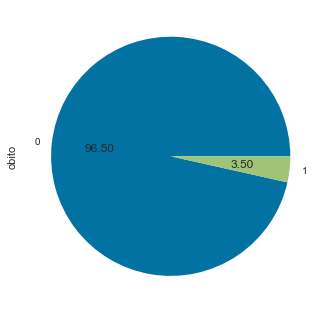

In [6]:
df['obito'].value_counts().plot.pie(autopct='%.2f')

In [7]:
# Instanciando o NearMIss
under_sampler = RandomUnderSampler(sampling_strategy=1) # FLOAT

In [8]:
# Aplicando o NearMiss nos dados para igualar a quantidade de amostras das classes
X_res, y_res = under_sampler.fit_resample(X, y)

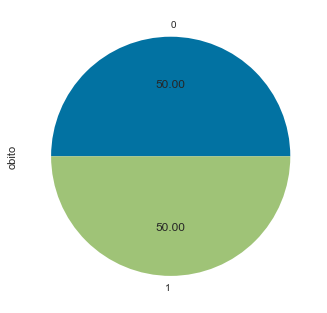

In [9]:
ax = y_res.value_counts().plot.pie(autopct='%.2f')

In [10]:
y_res.value_counts()

0    152502
1    152502
Name: obito, dtype: int64

# 4 - Modelagem

Utilizando oa função tools.add_constant() do pacote statsmodel adicionaremos uma coluna contendo apenas '1' na matriz X que servirar como entidade de coeficiante de intepretação do modelo

In [11]:
X_res = sm.tools.add_constant(X_res)

In [12]:
X_res.head(4)

,const,doenca_hepatica,cardiopatia,outros_fatores_de_risco,doenca_neurologica,pneumopatia,cs_sexo,idade
0,1.0,0,0,0,0,0,1,21.0
1,1.0,0,0,0,0,0,1,45.0
2,1.0,0,0,0,0,0,0,51.0
3,1.0,0,0,0,0,0,0,28.0


## 4.1 - Dividindo entre Treino e Teste

In [14]:
seed = 123
size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res, test_size = size, random_state = seed)

In [15]:
print('Treino: ',X_train.shape, y_train.shape , '\nTeste: ', X_test.shape, y_test.shape) #

Treino:  (213502, 8) (213502,) 
Teste:  (91502, 8) (91502,)


In [16]:
X_train.head()

,const,doenca_hepatica,cardiopatia,outros_fatores_de_risco,doenca_neurologica,pneumopatia,cs_sexo,idade
167104,1.0,0,1,1,0,0,1,68.0
53768,1.0,0,0,0,0,0,0,25.0
86330,1.0,0,0,0,0,0,1,60.0
170993,1.0,0,1,1,0,0,0,87.0
169098,1.0,0,0,1,0,0,1,53.0


# Regressão Logistitca

In [17]:
# Vamos instanciar o modelo e dar um Fit ()
logit = sm.Logit(y_train, X_train)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.398772
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  obito   No. Observations:               213502
Model:                          Logit   Df Residuals:                   213494
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.4247
Time:                        16:06:02   Log-Likelihood:                -85139.
converged:                       True   LL-Null:                   -1.4799e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -4.2078      0.022   -188.812      0.000      -4.251   

De modo a facilitar a interpretacao dos resultados, os dados serao gerados em termos percentuais relativos, esse percentual se aproxima da interpretação de um modelo de regressão linear

In [18]:
lista_coef = [0.0749 , 0.9278, 0.8771, 3.0315,2.3464,1.8831]
for elemento in lista_coef:
    print(round((np.exp(elemento) - 1) * 100,2))

7.78
152.89
140.39
1972.83
944.79
557.39


- Para cada ano a mais de idade, as chances de morte aumentam diminuem 7%.
-  Para pessoas com problemas de cardiopatia tem 115% mais chances de obito. 
-  Para pessoas com problemas de diabetes tem 84% mais chances de obito. 
-  Para pessoas com problemas de obesiade tem 625% mais chances de obito. 
-  Para pessoas com problemas de outros fatores de risco tem 481% mais chances de obito. 
-  Para pessoas com problemas de pneumopatia tem 239% mais chances de obito. 

In [19]:
#### Usando Sklearn
# Criando matriz X sem a constante
X1 = X_res.drop('const', axis=1)
X1_train = X_train.drop('const',axis=1)
X1_test = X_test.drop('const',axis=1)

# Criando a variavel target continua sendo Y_res


In [20]:
model = LogisticRegression(fit_intercept=True, penalty='l2', C = 1e10,)
model.fit(X1_train,y_train)

LogisticRegression(C=10000000000.0)

In [21]:
model.intercept_,model.coef_

(array([-4.20425599]),
 array([[ 2.57229361,  1.24467098,  2.57089894,  2.33065777,  1.8281457 ,
         -0.56303521,  0.07312725]]))

Faremos a previsao y_pred dos nossos targets usando a função .predict() aplicada aos dados de treino X_test

In [22]:
y_pred = model.predict(X1_test)
y_pred

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

In [ ]:
# Previsão de test
pred_test = model.predict([[80,1,0,0,1,0]])
pred_test

In [24]:
y_test.value_counts()

1    45842
0    45660
Name: obito, dtype: int64

## Matriz de confusao

<AxesSubplot:>

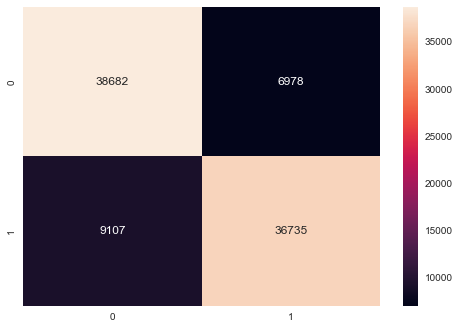

In [25]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt = 'd')

In [26]:
acuracia = accuracy_score(y_test,y_pred)
display(acuracia)

0.8242114926449695

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     45660
           1       0.84      0.80      0.82     45842

    accuracy                           0.82     91502
   macro avg       0.82      0.82      0.82     91502
weighted avg       0.82      0.82      0.82     91502



# Curva Roc

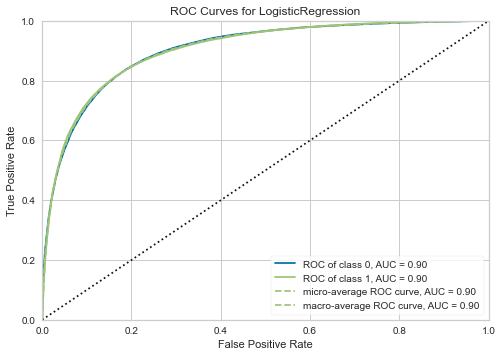

In [28]:
visualizer = ROCAUC(model, classes = [0, 1])

visualizer.fit(X1_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X1_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

# KNN 

In [29]:
knn = KNeighborsClassifier(n_neighbors= 5)

knn.fit(X_train,
       y_train
       )
y_pred = knn.predict(X_test)

<AxesSubplot:>

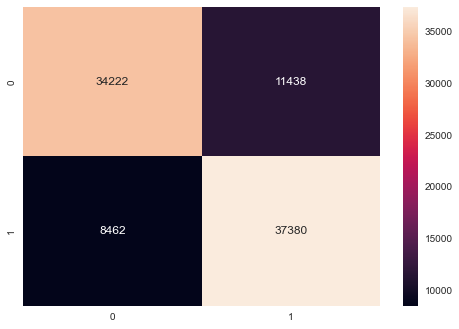

In [30]:
# Aplicando o KNN nos dados de teste.
y_pred = knn.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

# plotando a matriz de confusao
sns.heatmap(cnf_matrix, annot = True, fmt = 'd')


In [31]:
# Imprimindo as métricas
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.80      0.75      0.77     45660
     class 1       0.77      0.82      0.79     45842

    accuracy                           0.78     91502
   macro avg       0.78      0.78      0.78     91502
weighted avg       0.78      0.78      0.78     91502



# SVC

In [32]:
svc_clf = SVC()

svc_clf.fit(X1_train, y_train)

SVC()

In [33]:
y_pred = svc_clf.predict(X1_test)

In [34]:
# acurácia
accuracy = accuracy_score(y_test, y_pred)

# recall
recall = recall_score(y_test, y_pred)

# precision
precision = precision_score(y_test, y_pred)

# mostra as métricas do modelo
print(f'Accurácia: {round(accuracy, 3)}')
print(f'Recall: {round(recall, 3)}')
print(f'Precision: {round(recall, 3)}')

Accurácia: 0.821
Recall: 0.815
Precision: 0.815


# Outros Classificadores

Rodando outros classificadores de Machine Learning
Os resultados não são satisfatórios. Uma coisa que podemos fazer é resolver esse problema tentar alguns modelos, testar no nosso dataset e optear pelo que se sai melhor.

In [35]:
classifiers = [
    KNeighborsClassifier(),
    GaussianNB(),
    LogisticRegression(max_iter = 5000),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
]

In [36]:
for clf in classifiers:

    clf.fit(X_train, y_train)
    # armazenando o nome do modelo na variável name
    name = clf.__class__.__name__
    # imprimindo o nome do modelo
    print("=" * 30)
    print(name)
    # imprimindo os resultados do modelo
    print('****Results****')
    y_pred = clf.predict(X_test)
    print("Accuracy:", metrics.accuracy_score(y_test, 
                                              y_pred
                                             )
         )
    print("Precision:", metrics.precision_score(y_test, 
                                                y_pred
                                               )
         )
    print("Recall:", metrics.recall_score(y_test, 
                                          y_pred
                                         )
         )

KNeighborsClassifier
****Results****
Accuracy: 0.782518414898035
Precision: 0.765701175795813
Recall: 0.815409449849483
GaussianNB
****Results****
Accuracy: 0.7364975628948001
Precision: 0.9349505624274449
Recall: 0.5094891147855678
LogisticRegression
****Results****
Accuracy: 0.8242114926449695
Precision: 0.8403678539564889
Recall: 0.8013393830984686


# 9 - Time series

In [83]:
# convertendo a coluna data_inicio_sintomas para datetime
df['data_inicio_sintomas'] = pd.to_datetime(df['data_inicio_sintomas'].astype('datetime64'))

In [84]:
# sorting pela data
df =df.sort_values(by='data_inicio_sintomas', ascending=True)

In [86]:
# colocando a coluna de data como index
df= df.set_index('data_inicio_sintomas')

In [87]:
menor_data = df.index.min()
maior_data = df.index.max()
print('Temos uma serie temporal com data incial em :' , menor_data, 'e data final em :',maior_data)

Temos uma serie temporal com data incial em : 2020-02-04 00:00:00 e data final em : 2021-11-05 00:00:00


In [90]:
# dataframe com data dos obitos
df_temporal = pd.DataFrame(df[['obito']])

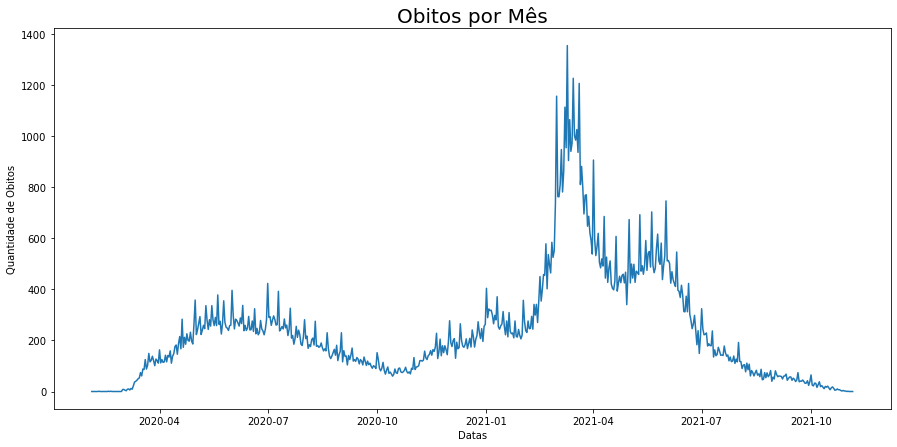

In [91]:
# ploto dos obitos ao longo dos meses
plt.rcParams['figure.figsize'] = (15,7)
plt.plot(df_temporal.reset_index().groupby('data_inicio_sintomas').sum())
plt.title('Obitos por Mês',fontsize=20)
plt.ylabel('Quantidade de Obitos')
plt.xlabel('Datas')
plt.show()

In [93]:
# substituindo 0:'recuperado',1:'falecido'
df_temporal['obito']=df_temporal['obito'].map({0:'recuperado',1:'falecido'})

# 3.2 - Encoders

# 3.2.1 - Colunas Discretas

In [94]:
# passando o encoder
encoder = ce.BinaryEncoder(cols=['obito'])
dfbin = encoder.fit_transform(df_temporal['obito'])

In [95]:
# falecidos e recuperados por mes
dfbin_month = dfbin.reset_index().groupby('data_inicio_sintomas').sum()
dfbin_month = dfbin_month.rename(columns={'obito_0':'falecido', 'obito_1': 'recuperado'})

In [96]:
# aplicando minmax scaler para que os obitos e recuperados fiquem na mesma escala
scaler = MinMaxScaler()
dfbin_month_scaled = scaler.fit_transform(dfbin_month)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


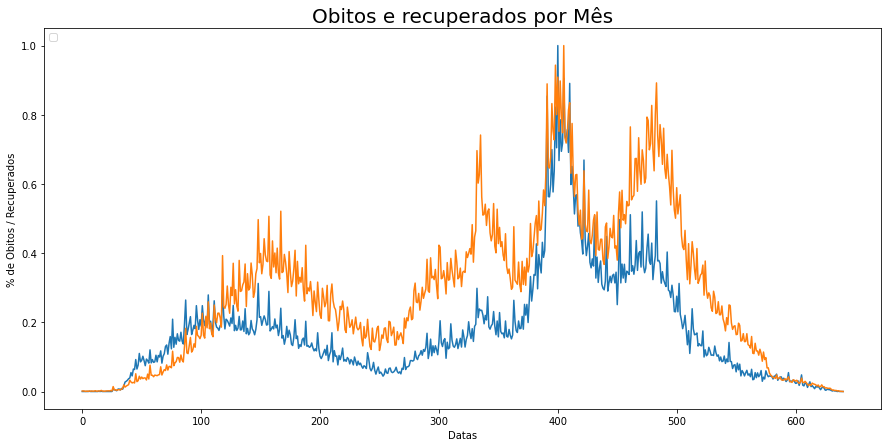

In [97]:
# plot de obitos e recuperados por mes (mesma escala)
plt.rcParams['figure.figsize'] = (15,7)
plt.plot(dfbin_month_scaled)
plt.title('Obitos e recuperados por Mês',fontsize=20)
plt.ylabel('% de Obitos / Recuperados')
plt.xlabel('Datas')
plt.legend(loc="upper left")
plt.show()

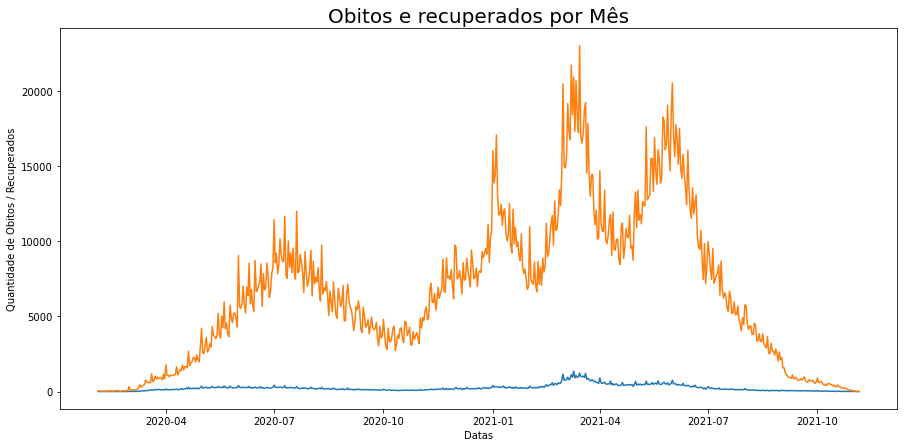

In [98]:
# plot de obitos e recuperados por mes (escalas diferentes)
plt.rcParams['figure.figsize'] = (15,7)
plt.plot(dfbin_month)
plt.title('Obitos e recuperados por Mês',fontsize=20)
plt.ylabel('Quantidade de Obitos / Recuperados')
plt.xlabel('Datas')
plt.show()

In [ ]:
model_logistic = LogisticRegression()

- Câncer: 5,6%
- Hipertensão: 6%
- Doença respiratória crônica: 6,3%
- Diabetes: 7,3%
- Doença cardiovascular: 10,5%

utilizar o statmodel para ter os betas e ver quais sao as features mais importanes 

fazer o feature importa

- 




se o periodo nao for o mesmo voce pode criar uma variavel categorica